In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings

import derivative

In [2]:
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python')
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')

In [3]:
warnings.filterwarnings("ignore", category=SyntaxWarning)
import lumapi

In [4]:
nm = 1e-9
um = 1e-6
c = 3e8

In [5]:
emeApi = lumapi.MODE()

In [6]:
emeApi.switchtolayout()
emeApi.deleteall()

In [7]:
materialClad = "SiO2 (Glass) - Palik"
materialSi = "Si (Silicon) - Palik"

In [8]:
#slab data
width = 450*nm
height = 220*nm
length = 155.287078587044064*um


In [9]:
emeApi.addstructuregroup()
dev_layer = 'GDS_LAYER_35:4'
emeApi.set('name', dev_layer)

In [10]:
emeApi.addrect()
emeApi.addtogroup(dev_layer)
emeApi.set('name','slab')
emeApi.set('x',0)
emeApi.set('x span', length)
emeApi.set('y',0)
emeApi.set('y span', width)
emeApi.set('z',height/2)
emeApi.set('z span', height)
emeApi.set('material', materialSi)

FDE settings - to get neff vs wavelength

In [11]:
emeApi.addfde()
bound_x_offset = 0.5*um
bound_y_offset = 2*um
bound_z_offset = 0.5*um



In [12]:
emeApi.set('solver type', '2D X normal')
emeApi.set('background material', 'SiO2 (Glass) - Palik')
emeApi.set('x',0)
emeApi.set('y', 0)
emeApi.set('y span', width + 2*bound_y_offset)
emeApi.set('z', height/2)

emeApi.set('mesh cells y', 100)
emeApi.set('mesh cells z', 100)
emeApi.set('y min bc', 'Metal')
emeApi.set('y max bc', 'Metal')
emeApi.set('z min bc', 'Metal')
emeApi.set('z max bc', 'Metal')

In [13]:
emeApi.switchtolayout()
emeApi.set('track selected mode', 1)
emeApi.set('number of points', 100)
emeApi.set('wavelength', 1.6*um)
emeApi.set('stop wavelength', 1.5*um)
emeApi.findmodes()
emeApi.selectmode(1)
neff_mode1 = []

emeApi.frequencysweep()

neff_sweep = emeApi.real(emeApi.getdata('FDE::data::frequencysweep', 'neff'))

frequency_sweep = emeApi.getdata('FDE::data::frequencysweep', 'f')

wavelength_sweep = c/frequency_sweep

wavelength_values = np.linspace(1.5*um, 1.6*um, 6)

neff_mode1.append(emeApi.real(emeApi.getdata('mode1', 'neff')))


In [14]:
print(neff_mode1)

[2.2906153513791394]


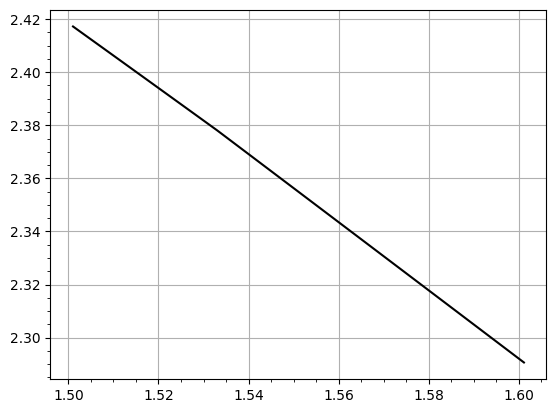

In [15]:
plt.minorticks_on()
plt.grid()
plt.plot(wavelength_sweep/um, neff_sweep, 'black', lw=1.5)

Group index calculation

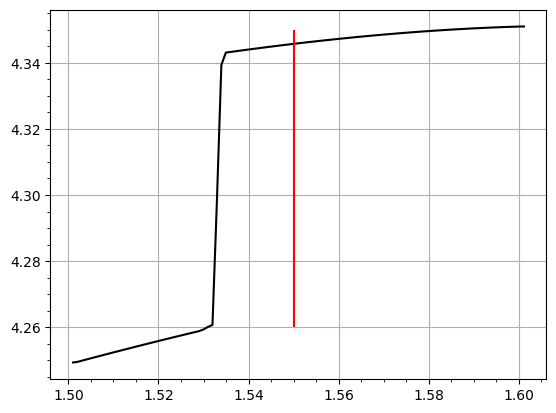

In [16]:
#neff(lambda)
lambda0 = 1550*nm

neff_lambda = np.column_stack((wavelength_sweep, neff_sweep))

derivative_neff = derivative.derivative(neff_lambda)

ng =  neff_sweep.flatten()- (derivative_neff[:,1]*wavelength_sweep.flatten())

plt.grid()
plt.minorticks_on()
plt.plot(derivative_neff[:,0]/um, ng, 'black', lw=1.5)
plt.vlines(1.550,ymin=4.26,ymax=4.35, color='r')

PLOT FSR

In [1]:
delta = 55.287078587044064
fsr = (wavelength_sweep.flatten())**2/(ng*delta*um)

plt.title(f'FSR vs Wavelength (delta = {delta} um)')
plt.plot(wavelength_sweep/um, fsr/nm, 'black', lw=1.5)

NameError: name 'wavelength_sweep' is not defined

Solver settings 

In [18]:
emeApi.switchtolayout()
emeApi.addeme()

In [19]:
#dimensions:
emeApi.set('x',0)
emeApi.set('x min', emeApi.getnamed(f'{dev_layer}::slab', 'x min'))
emeApi.set('y', 0)
emeApi.set('y span', width + 2*bound_y_offset)
emeApi.set('z', height/2)
emeApi.set('z span', height + 2*bound_z_offset)

emeApi.set('group spans',length)

#background material
emeApi.set('background material', materialClad)

In [20]:
emeApi.addemeprofile()
emeApi.set('name', 'profile')
emeApi.set('monitor type', 1)
emeApi.set('x', 2*um)
emeApi.set('y',0)
emeApi.set('y span', emeApi.getnamed('EME', 'y span'))
emeApi.set('z', height/2)

In [21]:
#boundary conditions
emeApi.switchtolayout()
emeApi.set('y min bc', 'Metal')
emeApi.set('y max bc', 'Metal')
emeApi.set('z min bc', 'Metal')
emeApi.set('z max bc', 'Metal')

LumApiError: 'in set, the requested property was not found'

In [22]:
emeApi.save('slab150')
emeApi.run()

In [23]:
emeApi.emepropagate()

In [24]:
interval = 0.1
emeApi.setemeanalysis('propagation sweep', 1)
emeApi.setemeanalysis('parameter', 'group span 1')
emeApi.setemeanalysis('start',1*um)
emeApi.setemeanalysis('stop', 1000*um)
emeApi.setemeanalysis('interval', interval)

In [25]:
emeApi.emesweep('propagation sweep')

In [26]:
S = emeApi.getemesweep('S')
group_span = S['group_span_1']

In [27]:
wl_start= 1500*nm
wl_stop = 1600*nm
nmbFrqPnts = 100
emeApi.setemeanalysis('wavelength sweep', 1)
emeApi.setemeanalysis('start wavelength', wl_start)
emeApi.setemeanalysis('stop wavelength', wl_stop)
emeApi.setemeanalysis('number of wavelength points', nmbFrqPnts)
emeApi.setemeanalysis('calculate group delays', 1)

In [28]:
emeApi.emesweep('wavelength sweep')
S = emeApi.getemesweep('S_wavelength_sweep')

In [30]:
emeApi.emepropagate()   
emeApi.exportemesweep('slab150um.dat') 

ValueError: x and y must have same first dimension, but have shapes (1000, 1) and (100,)

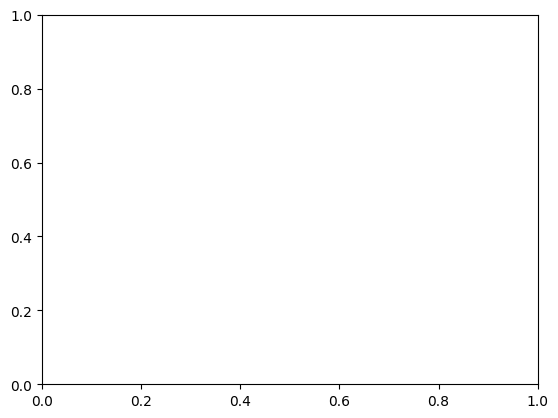

In [343]:
T = np.abs(S['s21'])**2
plt.plot(group_span/um, T, 'black', lw=1.5, label='Simulação')
plt.xlabel(r'Comprimento do taper $(\mu m)$', fontsize = 12)
plt.ylabel('Transmitância', fontsize = 12)
plt.xlim(1,10)
plt.ylim([0.7,1.05])
plt.legend()
plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.title(r'Transmitância vs L (Taper linear)')
plt.grid(True)